# Classifying Essential Genes with Bitome

## Setup

### Import Required Packages

In [1]:
from pathlib import Path
import sys
import uuid

import kerastuner
from kerastuner.tuners import RandomSearch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sparse
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate, RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from xgboost import XGBClassifier

BITOME_KB_PATH = Path('..', 'bitome-kb')
sys.path.append(BITOME_KB_PATH.absolute().as_posix())

from bitome.core import Bitome

### Define Global Variables

In [2]:
DATA_PATH = Path('..', 'data', 'classification', 'essential')
LOCAL_CACHE_PATH = Path('..', 'local_cache')
FIG_PATH = Path('..', 'figures', 'figure_4')

### Load Pre-Prepared Bitome Knowledgebase

In [3]:
bitome = Bitome.init_from_file(Path(LOCAL_CACHE_PATH, 'bitome.pkl'))

### Prepare Feature Matrix

We want to test sum and mean for combination of features across positions, and some different scalers to deal with non-normal distributions of features

In [4]:
# load the locus tags and essential labels for training
locus_tag_label_lookup = pd.read_csv(Path(DATA_PATH, 'train.csv'), index_col=0, squeeze=True)
y = locus_tag_label_lookup.values

# extract the sub-matrix for each locus tag
gene_sub_matrices = []
for locus_tag in locus_tag_label_lookup.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    gene_sub_matrices.append(sub_matrix)
    
# now we can sum, mean, and median across the positions
X_sum = np.array([np.asarray(sub_mat.toarray()).sum(axis=1) for sub_mat in gene_sub_matrices])
X_mean = np.array([np.asarray(sub_mat.toarray()).mean(axis=1) for sub_mat in gene_sub_matrices])
print(f'X shape: {X_sum.shape}')

X shape: (3349, 1634)


#### Feature Scaling

Let's try both MinMax and Robust scaling since we have many quite skewed features

In [5]:
min_max_scale = MinMaxScaler()
X_minmax_sum = min_max_scale.fit_transform(X_sum)
X_minmax_mean = min_max_scale.fit_transform(X_mean)

robust_scale = RobustScaler()
X_robust_sum = robust_scale.fit_transform(X_sum)
X_robust_mean = robust_scale.fit_transform(X_mean)

# prepare final X_matrices for each of our desired feature sets
X_to_try = {
    'minmax_sum': X_minmax_sum,
    'robust_sum': X_robust_sum,
    'minmax_mean': X_minmax_mean,
    'robust_mean': X_robust_mean
}

### Define Helper Functions

#### Bias/Class Weight for Neural Network

In [6]:
def bias_and_class_weight(y_train):
    # pre-compute the output bias and class weights; for imbalanced class handling
    # see https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    total = len(y_train)
    neg, pos = np.bincount(y_train)
    initial_bias = np.log((pos / neg))
    weight_for_0 = (1 / neg) * (total / 2.0) 
    weight_for_1 = (1 / pos) * (total / 2.0)
    class_weight = {0: weight_for_0, 1: weight_for_1}
    return initial_bias, class_weight

#### Run Neural Network

In [7]:
def run_nn_model(model_params, X_train, y_train, X_val, y_val, return_model=False):
    
    # pre-compute the output bias and class weights; for imbalanced class handling
    # see https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
    initial_bias, class_weight = bias_and_class_weight(y_train)

    # instantiate the Sequential model
    model = keras.Sequential()
    
    # add the hidden layers; use the He initialization method learned from NN course 
    for layer_size, dropout_rate in zip(model_params['hidden_layer_sizes'], model_params['dropout_rates']):
        model.add(layers.Dense(
            layer_size,
            activation='relu',
            kernel_initializer=keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.l2(model_params['l2'])
        ))
        model.add(layers.Dropout(dropout_rate))
    
    # add the output layer, using the initial bias computed above
    model.add(layers.Dense(1, activation='sigmoid', bias_initializer=keras.initializers.Constant(initial_bias)))
    
    # define the metrics we'd like to use
    metrics = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.AUC(name='auc')
    ]
    
    # compile the model using typical optimizer and loss function
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    # define an early stopping callback to prevent continued training if validation performance stops improving
    es_patience = 10
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_auc',
        verbose=1,
        patience=es_patience,
        mode='max',
        restore_best_weights=True
    )
    
    # now that we've done some computation in easier NumPy format, convert the matrices to tensors
    X_train, y_train, X_val, y_val = [tf.convert_to_tensor(mat) for mat in [X_train, y_train, X_val, y_val]]
    
    # fit the model to the training data
    model_history = model.fit(
        X_train,
        y_train,
        epochs=100,
        class_weight=class_weight,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    # get the INDEX of the best epoch for validation AUC before we early-stopped
    best_epoch = early_stopping.stopped_epoch - es_patience
    
    result_dict = {}
    for metric in model.metrics_names:
        result_dict[f'train_{metric}'] = model_history.history[metric][best_epoch]
        result_dict[f'test_{metric}'] = model_history.history[f'val_{metric}'][best_epoch]
    
    if return_model:
        return model
    else:
        return result_dict

#### Run scikit-learn Models

In [8]:
def run_models(models_dict, X_dict, y, cv=5, file_path=None):
    """
    Runs the provided models in the models_dict with the given X matrices and targets
    
    Models_dict and X_dict have key/value pairs in the following form -> model_name: model, X_name: X_matrix
    Uses sklearn's cross_validate under the hood
    """
    
    if file_path is not None and file_path.is_file():
        print('Loaded cached result!')
        return pd.read_csv(file_path, index_col=0)

    # instantiate an empty dataframe to store our results
    full_cv_result_df = pd.DataFrame()

    for model_name, model in models_dict.items():
        print(f'{model_name}')

        for X_name, X in X_dict.items():
            print(f'{model_name}: {X_name}')
            

            # fit the provided model to the training set; use Keras specifically for the NN
            # 'model' for the nn is actually a dict of model parameters
            if type(model) == dict:
                for train_index, val_index in StratifiedKFold(n_splits=cv, shuffle=True).split(X, y):
                    # use the StratifiedKFold-provided indices to split the training set
                    X_train, X_val, y_train, y_val = X[train_index], X[val_index], y[train_index], y[val_index]
                    result_row_dict = run_nn_model(model, X_train, y_train, X_val, y_val)
                    result_row_dict['model'] = model_name
                    result_row_dict['x_matrix'] = X_name
                    full_cv_result_df = full_cv_result_df.append(result_row_dict, ignore_index=True)
            else:
                
                # define the desired scoring metrics
                def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
                def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
                def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
                def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
                scoring = {
                    'tp': make_scorer(tp),
                    'tn': make_scorer(tn),
                    'fp': make_scorer(fp),
                    'fn': make_scorer(fn),
                    'auc': 'roc_auc',
                    'accuracy': 'accuracy'
                }
                
                # use stratified cross validation to assess model performance
                cv_result_df = pd.DataFrame(cross_validate(
                    model,
                    X,
                    y,
                    cv=cv,
                    scoring=scoring,
                    n_jobs=4,
                    return_train_score=True
                ))
                cv_result_df['model'] = [model_name] * cv
                cv_result_df['x_matrix'] = [X_name] * cv

                full_cv_result_df = full_cv_result_df.append(cv_result_df, ignore_index=True)
    
    # add a column that conveniently calculates the overfit difference (train - test score)
    full_cv_result_df['overfit'] = full_cv_result_df['train_auc'] - full_cv_result_df['test_auc']
    
    # save the result df so we don't have to run this initial screen again later
    if file_path is not None:
        full_cv_result_df.to_csv(file_path)
        
    return full_cv_result_df

#### Plot Model Performance

In [9]:
def plot_performance(result_df, confusion_matrix=False):
    
    if len(result_df['x_matrix'].unique()) > 1:
        hue = 'x_matrix'
    else:
        hue = None

    _, ax = plt.subplots(figsize=(10, 5))
    sns.swarmplot(x='model', y='test_auc', data=result_df, hue=hue, dodge=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=14)
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Val AUC', fontsize=15)

    _, ax = plt.subplots(figsize=(10, 5))
    sns.swarmplot(x='model', y='overfit', data=result_df, hue=hue, dodge=True, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=14)
    if hue is not None:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Overfit', fontsize=15)
    
    if confusion_matrix:
        
        unique_models = result_df['model'].unique()
        num_models = len(unique_models)
        if num_models == 1:
            subplot_dims, figsize = (1, 1), (4, 3)
        elif num_models == 2:
            subplot_dims, figsize = (1, 2), (8, 3)
        elif 3 <= num_models <= 4:
            subplot_dims, figsize = (2, 2), (8, 6)
        elif 5 <= num_models <= 6:
            subplot_dims, figsize = (2, 3), (12, 6)
        elif 7 <= num_models <= 8:
            subplot_dims, figsize = (2, 4), (12, 6)
        
        _, axs = plt.subplots(*subplot_dims, figsize=figsize)
        if num_models == 1:
            axs = [axs]
        else:
            axs = axs.flatten()

        for model_name, ax in zip(unique_models, axs):
            
            model_result_df = result_df[result_df['model'] == model_name]
            tn, fp, fn, tp = model_result_df[['test_tn', 'test_fp', 'test_fn', 'test_tp']].mean(axis=0)

            conf_mat = np.array([np.array([tn, fp]) / (tn + fp), np.array([fn, tp]) / (fn + tp)])

            sns.heatmap(
                conf_mat,
                cmap="PuBu",
                annot=True,
                annot_kws={'fontsize': 13},
                cbar=False,
                square=True,
                xticklabels=['Non-essential', 'Essential'],
                yticklabels=['Non-essential', 'Essential'],
                ax=ax
            )
            ax.tick_params(axis='both', labelsize=12)
            ax.tick_params(axis='y', rotation=0)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_visible(True)
            ax.spines['top'].set_visible(True)
            ax.spines['bottom'].set_visible(True)
            ax.set_title(model_name)
            ax.set_xlabel('Predicted Class', fontsize=12)
            ax.set_ylabel('True Class', fontsize=12)

        if len(axs) > num_models:
            axs[-1].set_visible(False)

        plt.tight_layout()

#### Run Models and Plot

In [10]:
def run_models_and_plot_performance(
        models_dict,
        X_dict,
        y,
        cv=5,
        scoring='roc_auc',
        file_path=None,
        confusion_matrix=False
    ):
    result_df = run_models(models_dict, X_dict, y, cv=5, file_path=file_path)
    plot_performance(result_df, confusion_matrix=confusion_matrix)
    return result_df

## Model Selection

### Define Models to Try

In [11]:
models_to_try = {
    'AdaBoost': AdaBoostClassifier(),
    'Logistic Regression': LogisticRegression(
        penalty='l1',
        solver='saga',
        class_weight='balanced'
    ),
    # define this specially; see the run_nn_model function above, we are using Keras for the neural networks
    # start with a super simple model
    'Neural Net': {
        'hidden_layer_sizes': [16],
        'dropout_rates': [0],
        'l2': 0
    },
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        dual=False,
        class_weight='balanced'
    ),
    'XGBoost': XGBClassifier(
        scale_pos_weight=np.divide(*np.bincount(y)),
        n_jobs=4
    )
}

### Out-of-the-Box Model/Feature Normalization Evaluation

Loaded cached result!


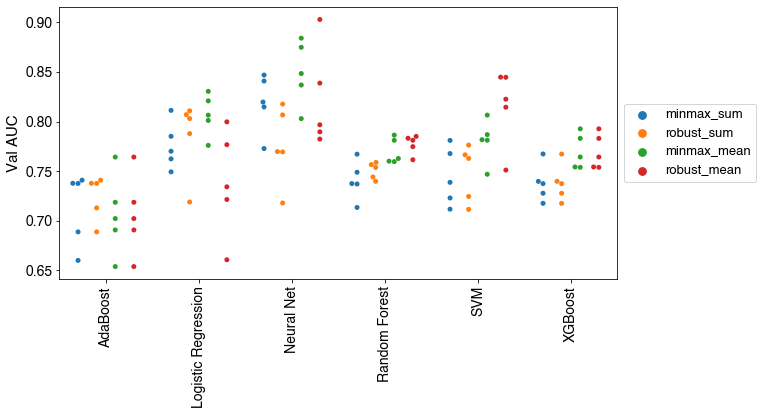

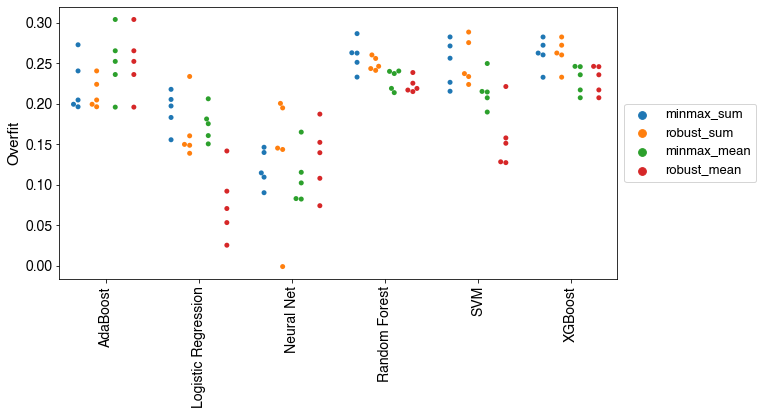

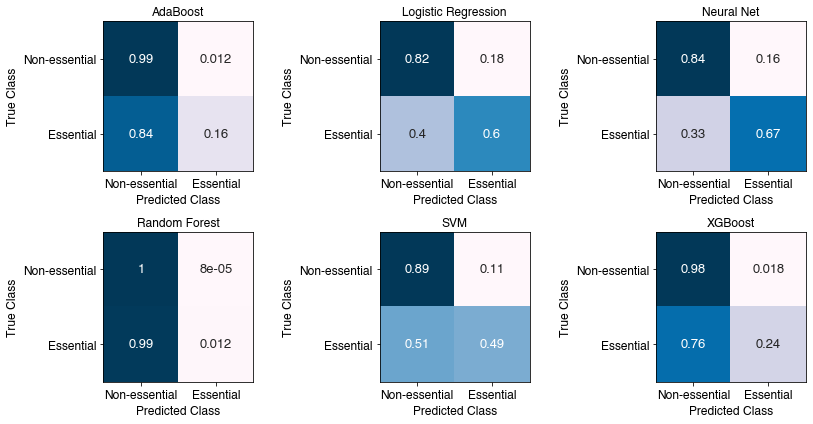

In [13]:
initial_eval_df = run_models_and_plot_performance(
    models_to_try,
    X_to_try,
    y,
    file_path=Path(DATA_PATH, 'initial_eval.csv'),
    confusion_matrix=True
)

So let's summarize these results:

- It looks like robust_mean is the best of the bunch
- The models are pretty not handling the class imbalance well yet, except the neural network is solid

### Sequence Feature Screening

In [14]:
X_to_try_seq = {
    'bitome': X_robust_mean,
    'seq_only': X_robust_mean[:, :8],
    'no_seq': X_robust_mean[:, 8:],
    'shuffled': np.random.permutation(X_robust_mean)
}

models_to_try_seq = models_to_try

Loaded cached result!


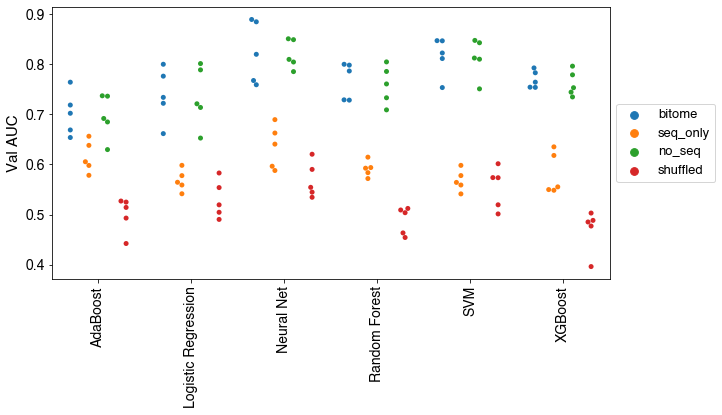

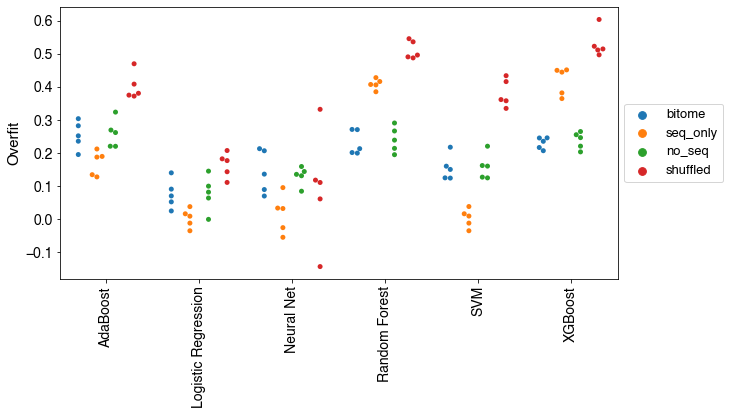

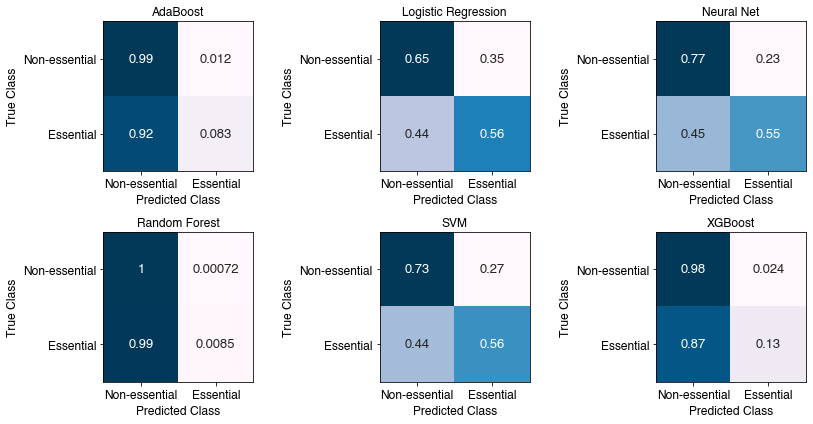

In [16]:
feature_eval_df = run_models_and_plot_performance(
    models_to_try_seq,
    X_to_try_seq,
    y,
    file_path=Path(DATA_PATH, 'feature_eval.csv'),
    confusion_matrix=True
)

So the bitome features are what we want; interestingly, the sequence features alone are not predictive really at all.

In [12]:
X = X_robust_mean

## Hyperoptimization

### Helper Functions

In [40]:
def hyperoptimize_nn(param_dict, X, y, n_iter=50, project_name=None):
    
    # create a 70/30 train/test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)
    
    # compute the initial bias and class weight settings (see run_nn_model for link to TF tutorial)
    initial_bias, class_weight = bias_and_class_weight(y_train)
    
    # define a build_model function, needed for Keras tuner to work properly
    # this is where we add in the parameters from the param_dict
    l2_low, l2_high = param_dict['l2']
    if l2_high == 0:
        l2_sampling = None
    else:
        l2_sampling = 'log'
    def build_model(hp):
        
        # construct the neural network, using the hyperparameters syntax from keras tuner
        model = keras.Sequential()
        for i in range(hp.Int('n_hidden_layers', *param_dict['n_hidden_layers'])):
            model.add(layers.Dense(
                units=hp.Int('units_' + str(i), *param_dict['hidden_layer_size']),
                activation='relu',
                kernel_initializer=keras.initializers.HeNormal(),
                kernel_regularizer=keras.regularizers.l2(hp.Float('l2', l2_low, l2_high, sampling=l2_sampling))
            ))
            model.add(layers.Dropout(hp.Float('rate', *param_dict['dropout_rate'])))
        model.add(layers.Dense(
            1,
            activation='sigmoid',
            bias_initializer=tf.keras.initializers.Constant(initial_bias)
        ))
        
        # define the metrics to use
        metrics = [
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalseNegatives(name='fn'), 
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(name='auc')
        ]
        
        # compile the model using typical optimizer and loss function
        model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.BinaryCrossentropy(),
            metrics=metrics
        )
        
        return model
    
    # determine the directory name to use; if this matches an existing run, that run will be
    # resumed/reloaded from the local cache
    if project_name is None:
        project_name = f'essential_hyperopt_{str(uuid.uuid4())}'

    # now we can instantiate a Keras tuner object using this build_model function
    tuner = RandomSearch(
        build_model,
        objective=kerastuner.Objective("val_auc", direction="max"),
        max_trials=n_iter,
        executions_per_trial=1,
        directory=LOCAL_CACHE_PATH,
        project_name=project_name
    )
    
    # define an early stopping callback to prevent continued training if validation performance stops improving
    es_patience = 10
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_auc',
        verbose=1,
        patience=es_patience,
        mode='max',
        restore_best_weights=True
    )

    # run the hyperoptimization
    tuner.search(
        X_train,
        y_train,
        epochs=100,
        class_weight=class_weight,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        verbose=0
    )
    
    # access the best models and evaluate each on the test set
    result_df = pd.DataFrame()
    trained_models = tuner.get_best_models(num_models=n_iter)
    hyperparams = [hp.values for hp in tuner.get_best_hyperparameters(num_trials=n_iter)]
    for trained_model, hyperparam_dict in zip(trained_models, hyperparams):

        result_dict = hyperparam_dict
        
        # re-train the model
        model_history = trained_model.fit(
            X_train,
            y_train,
            epochs=100,
            class_weight=class_weight,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val),
            verbose=0
        )

        # get the INDEX of the best epoch for validation AUC before we early-stopped
        best_epoch = early_stopping.stopped_epoch - es_patience

        for metric in trained_model.metrics_names:
            result_dict[f'mean_train_{metric}'] = model_history.history[metric][best_epoch]
            result_dict[f'mean_test_{metric}'] = model_history.history[f'val_{metric}'][best_epoch]

        result_df = result_df.append(result_dict, ignore_index=True)
    
    return result_df

In [19]:
def hyperoptimize(models_dict, X, y, n_iter=50, cv=5, file_path=None):
    """
    Given a dictionary of hyperoptimization values and models, run through a RandomizedSearchCV for each model 
    and save the raw results in a dataframe
    """
    
    # cleverly just return the results from file if the filename already exists
    if file_path is not None and file_path.is_file():
        print('Loaded cached result!')
        return pd.read_csv(file_path, index_col=0)
    
    # instantiate an empty DataFrame to which to append parameter search results
    hyperopt_result_df = pd.DataFrame()

    for model_name, model_hyperopt_dict in models_dict.items():
        print(model_name)
        
        # handle the neural network specially 
        if model_name == 'Neural Net':
            if file_path is not None:
                project_name = f'essential_{file_path.parts[-1][:-4]}'
            else:
                project_name = None
            rs_result_df = hyperoptimize_nn(model_hyperopt_dict, X, y, n_iter=n_iter, project_name=project_name)
            rs_result_df['model'] = [model_name] * rs_result_df.shape[0]
        else:
        
            # figure out if this hyperopt dict asked for a particular number of iterations
            if model_hyperopt_dict.get('n_iter', 0) > 0:
                n_iter = model_hyperopt_dict['n_iter']

            # define the desired scoring metrics
            def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
            def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
            def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
            def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
            scoring = {
                'tp': make_scorer(tp),
                'tn': make_scorer(tn),
                'fp': make_scorer(fp),
                'fn': make_scorer(fn),
                'auc': 'roc_auc',
                'accuracy': 'accuracy'
            }

            random_search_hyperopt = RandomizedSearchCV(
                model_hyperopt_dict['model'],
                model_hyperopt_dict['param_dists'],
                n_iter=n_iter,
                cv=cv,
                scoring=scoring,
                refit=False,
                n_jobs=4,
                verbose=1,
                return_train_score=True
            )

            random_search_hyperopt.fit(X, y)

            rs_result_df = pd.DataFrame(random_search_hyperopt.cv_results_)
            rs_result_df['model'] = [model_name] * rs_result_df.shape[0]
            
        hyperopt_result_df = hyperopt_result_df.append(rs_result_df)
    
    if file_path is not None:
        hyperopt_result_df.to_csv(file_path)

    return hyperopt_result_df

#### Plot Hyperoptimization Performance

In [33]:
def plot_hyperoptimization_performance(hyperopt_result_df, hyperopt_models):
    
    # plot the overall performance of the models
    _, ax = plt.subplots()
    sns.swarmplot(x='model', y='mean_test_auc', data=hyperopt_result_df, ax=ax)
    ax.tick_params(axis='x', rotation=90)
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xlabel('')
    ax.set_ylabel('Mean Val AUC')
    
    # for each model, identify the top 5 performing models based on the following criteria:
    # we care about both total performance and overfitting; let's define a metric that subtracts the overfit 
    # amount from the test performance; we also care about percentage breakdown of each class being classified;
    # this amounts to the fp and tp rates
    hyperopt_result_df[['tn', 'fp']] = hyperopt_result_df[['mean_test_tn', 'mean_test_fp']].divide(
        hyperopt_result_df['mean_test_tn'] + hyperopt_result_df['mean_test_fp'], axis=0
    )
    hyperopt_result_df[['fn', 'tp']] = hyperopt_result_df[['mean_test_fn', 'mean_test_tp']].divide(
        hyperopt_result_df['mean_test_fn'] + hyperopt_result_df['mean_test_tp'], axis=0
    )
    hyperopt_result_df['overfit'] = hyperopt_result_df['mean_train_auc'] - hyperopt_result_df['mean_test_auc']
    hyperopt_result_df['performance'] = hyperopt_result_df['mean_test_auc'] - hyperopt_result_df['overfit'] + (
        hyperopt_result_df[['tn', 'tp']].mean(axis=1) - hyperopt_result_df[['tn', 'tp']].std(axis=1)
    )

    num_models = len(hyperopt_result_df['model'].unique())
    if num_models == 1:
        subplot_dims, figsize = (1, 1), (4, 3)
    elif num_models == 2:
        subplot_dims, figsize = (1, 2), (8, 3)
    elif 3 <= num_models <= 4:
        subplot_dims, figsize = (2, 2), (8, 6)
    elif 5 <= num_models <= 6:
        subplot_dims, figsize = (2, 3), (12, 6)
    elif 7 <= num_models <= 8:
        subplot_dims, figsize = (2, 4), (12, 6)

    _, axs = plt.subplots(*subplot_dims, figsize=figsize)
    if num_models == 1:
        axs = [axs]
    else:
        axs = axs.flatten()

    for (model_name, hyperopt_dict), ax in zip(hyperopt_models.items(), axs):
        print(model_name)
        
        model_result_df = hyperopt_result_df[hyperopt_result_df['model'] == model_name]
        model_result_df = model_result_df.sort_values(by='performance', ascending=False)
        
        # identify the parameter columns we want to pull out
        if model_name == 'Neural Net':
            param_column_names = ['n_hidden_layers', 'units_0', 'rate', 'l2']
        else:
            param_column_names = [f'param_{param_name}' for param_name in hyperopt_dict['param_dists'].keys()]
        conf_mat_names = ['tn', 'fn', 'fp', 'tp']
            
        column_names = ['mean_train_auc', 'mean_test_auc', 'mean_test_accuracy'] + param_column_names + conf_mat_names
        
        # extract and display the desired columns for the given model
        model_result_df = model_result_df[column_names]
        display(model_result_df.iloc[:10, :])
        
        # create and display a confusion matrix for the best-performing model
        tn, fn, fp, tp = model_result_df[conf_mat_names].iloc[0, :]
        conf_mat = np.array([np.array([tn, fp]), np.array([fn, tp])])
        sns.heatmap(
            conf_mat,
            cmap="PuBu",
            annot=True,
            annot_kws={'fontsize': 13},
            cbar=False,
            square=True,
            xticklabels=['Non-essential', 'Essential'],
            yticklabels=['Non-essential', 'Essential'],
            ax=ax
        )
        ax.tick_params(axis='both', labelsize=12)
        ax.tick_params(axis='y', rotation=0)
        ax.spines['right'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.set_title(model_name)
        ax.set_xlabel('Predicted Class', fontsize=12)
        ax.set_ylabel('True Class', fontsize=12)
        
    plt.tight_layout()

## Hyperparameter Optimization

Let's try some hyperparameter optimization on all of these above models

Running notes: 
- Round 1: The boosted tree methods really did poorly, dropping them.
- Round 2: Everything but the NN is disappointing on either balance or performance; dropping all but NN
- Round 3: Tried some L2 regularization, that helped with balance
- Round 4: Added dropout (small amount), that helps too; keep pushing these regularization methods
- Round 5: seems like 32 layers is enough
- Round 6: with NN, dropout rate above 0.1 seems good
- Round 7: more dropout with less L2 is looking good
- Round 8: fine-tuning
- Round 9: more fine-tuning
- Round 10: with fine-tuned regularization, adding a second layer does better

In [96]:
hyperopt_models = {
#     'AdaBoost': {
#         'model': AdaBoostClassifier(
#             base_estimator=DecisionTreeClassifier(max_depth=1)
#         ),
#         'param_dists': {
#             'n_estimators': np.arange(5, 100, 5),
#             'learning_rate': np.logspace(0.01, 10, num=25)
#         }
#     },
#     'Logistic Regression': {
#         'model': LogisticRegression(
#             penalty='l1',
#             class_weight='balanced',
#             solver='saga'
#         ),
#         'param_dists': {
#             'C': np.logspace(-8, -3, num=25)
#         }
#     },
    'Neural Net': {
        'n_hidden_layers': (2, 2),
        'hidden_layer_size': (32, 32),
        'dropout_rate': (0.001, 0.1),
        'l2': (0.0001, 0.005)
    }
#     'Random Forest': {
#         'model': RandomForestClassifier(
#             class_weight='balanced',
#             n_jobs=4
#         ),
#         'param_dists': {
#             'n_estimators': np.arange(25, 250, 5),
#             'max_depth': np.arange(1, 5),
#             'min_samples_split': np.arange(2, 10),
#             'min_samples_leaf': np.arange(2, 10)
#         }
#     },
#     'SVM': {
#         'model': LinearSVC(
#             penalty='l1',
#             class_weight='balanced',
#             dual=False
#         ),
#         'param_dists': {
#             'C': np.logspace(-8, -3, num=25)
#         }
#     },
#     'XGBoost': {
#         'model': XGBClassifier(
#             scale_pos_weight=np.divide(*np.bincount(y)),
#             n_jobs=4
#         ),
#         'param_dists': {
#             'n_estimators': np.arange(5, 100),
#             'learning_rate': np.logspace(0.01, 100, num=25),
#             'reg_lambda': np.logspace(1, 1e5, num=25),
#             'reg_alpha': np.logspace(0.1, 1e4, num=25)
#         }
#     }
}

Loaded cached result!
Neural Net


,mean_train_auc,mean_test_auc,mean_test_accuracy,n_hidden_layers,units_0,rate,l2,tn,fn,fp,tp
5,0.951730,0.858936,0.808955,2.0,32.0,0.021368,0.000514,0.808989,0.191489,0.191011,0.808511
19,0.938064,0.863871,0.800000,2.0,32.0,0.091891,0.000107,0.796148,0.148936,0.203852,0.851064
23,0.913211,0.855521,0.817910,2.0,32.0,0.062469,0.003670,0.821830,0.234043,0.178170,0.765957
14,0.961976,0.857518,0.831343,2.0,32.0,0.034729,0.000276,0.834671,0.212766,0.165329,0.787234
9,0.956190,0.865237,0.838806,2.0,32.0,0.044315,0.002494,0.844302,0.234043,0.155698,0.765957
6,0.974163,0.869796,0.841791,2.0,32.0,0.074211,0.000182,0.847512,0.234043,0.152488,0.765957
8,0.978811,0.884447,0.852239,2.0,32.0,0.068391,0.004714,0.860353,0.255319,0.139647,0.744681
18,0.973678,0.856050,0.822388,2.0,32.0,0.003782,0.000280,0.826645,0.234043,0.173355,0.765957
10,0.931194,0.855760,0.832836,2.0,32.0,0.073851,0.000958,0.841091,0.276596,0.158909,0.723404
0,0.958734,0.864673,0.844776,2.0,32.0,0.091595,0.000333,0.853933,0.276596,0.146067,0.723404


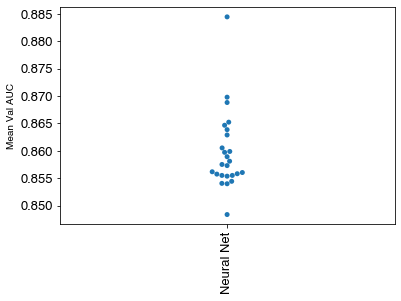

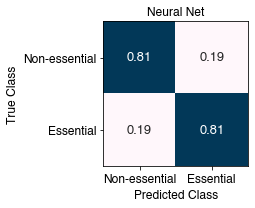

In [99]:
plot_hyperoptimization_performance(
    hyperoptimize(hyperopt_models, X, y, file_path=Path(DATA_PATH, 'hyperopt_10.csv'), n_iter=25),
    hyperopt_models
)

### Save Our Best Models as We Go

In [100]:
best_models_after_hyperopt = {
    'AdaBoost': AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=20,
        learning_rate=0.85
    ),
    'Logistic Regression': LogisticRegression(
        penalty='l1', 
        C=0.05,
        class_weight='balanced',
        solver='saga'
    ),
    'Neural Net': {
        'hidden_layer_sizes': [32, 32],
        'dropout_rates': [0.02, 0.02],
        'l2': 0.0005
    },
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=1,
        min_samples_split=5,
        min_samples_leaf=5,
        class_weight='balanced',
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        C=0.1,
        class_weight='balanced',
        dual=False
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50,
        learning_rate=1.5,
        scale_pos_weight=np.divide(*np.bincount(y)),
        reg_lambda=1e4,
        reg_alpha=75,
        n_jobs=4
    )
}

### Hyperoptimized Performance

Loaded cached result!


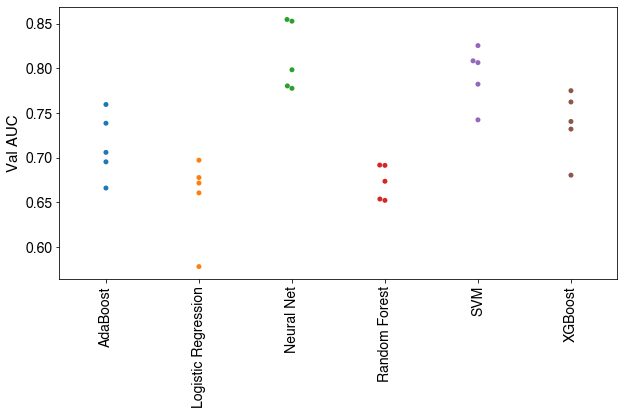

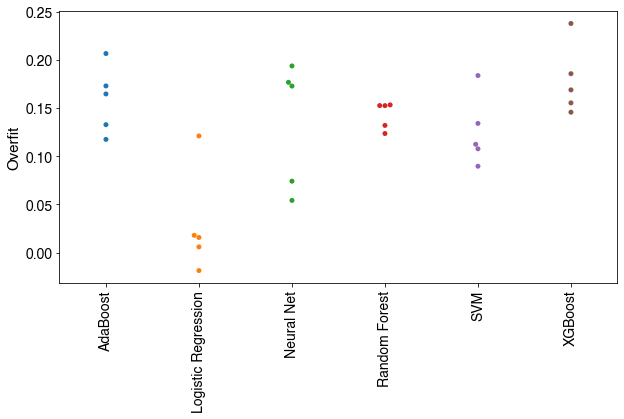

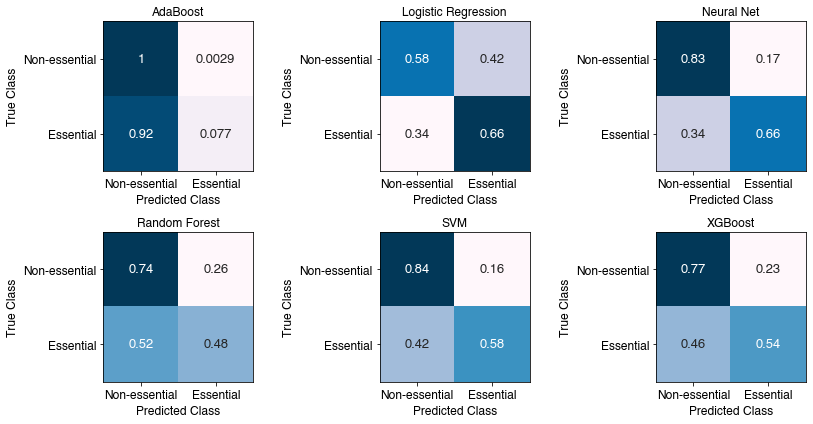

In [102]:
final_hyperopt_df = run_models_and_plot_performance(
    best_models_after_hyperopt,
    {'X_hyperopt': X},
    y,
    file_path=Path(DATA_PATH, 'post_hyperopt_eval.csv'),
    confusion_matrix=True
)

## Test Set Evaluation

### Load Test Data

In [26]:
# load the locus tags and SNP labels for the lockbox
locus_tag_label_lookup_lockbox = pd.read_csv(Path(DATA_PATH, 'test.csv'), index_col=0, squeeze=True)
y_lockbox = locus_tag_label_lookup_lockbox.values

# extract the sub-matrix for each locus tag
GENE_SUB_MATRICES_LOCKBOX = []
for locus_tag in locus_tag_label_lookup_lockbox.index:
    
    # find the Gene object from the Bitome KB
    for g in bitome.genes:
        if g.locus_tag == locus_tag:
            gene = g
            break
            
    # pull out the relevant portion of the matrix
    location = gene.location
    gene_range = location.start.position, location.end.position
    sub_matrix = bitome.extract(column_range=gene_range).tocsc()
    
    GENE_SUB_MATRICES_LOCKBOX.append(sub_matrix)
    
X_LOCKBOX_ORIG = np.array([np.asarray(sub_mat.toarray()).mean(axis=1) for sub_mat in GENE_SUB_MATRICES_LOCKBOX])
print(f'{X_LOCKBOX_ORIG.shape}')

X_lockbox = RobustScaler().fit_transform(X_LOCKBOX_ORIG)

(838, 1634)


### Evaluate Best Models on Test Data after Re-training

In [27]:
test_models = {
    'AdaBoost': AdaBoostClassifier(
        base_estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=20,
        learning_rate=0.85
    ),
    'Logistic Regression': LogisticRegression(
        penalty='l1', 
        C=0.05,
        class_weight='balanced',
        solver='saga'
    ),
    'Neural Net': {
        'hidden_layer_sizes': [32, 32],
        'dropout_rates': [0.02, 0.02],
        'l2': 0.0005
    },
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=1,
        min_samples_split=5,
        min_samples_leaf=5,
        class_weight='balanced',
        n_jobs=4
    ),
    'SVM': LinearSVC(
        penalty='l1',
        C=0.1,
        class_weight='balanced',
        dual=False
    ),
    'XGBoost': XGBClassifier(
        n_estimators=50,
        learning_rate=1.5,
        scale_pos_weight=np.divide(*np.bincount(y)),
        reg_lambda=1e4,
        reg_alpha=75,
        n_jobs=4
    )
}

In [28]:
lockbox_eval_df = pd.DataFrame(columns=['model', 'accuracy', 'auc', 'tn', 'fp', 'fn', 'tp'])

for model_name, model in test_models.items():
    print(model_name)
    if model_name == 'Neural Net':
        X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X, y, test_size=0.2, stratify=y)
        nn_model = run_nn_model(model, X_train_nn, y_train_nn, X_val_nn, y_val_nn, return_model=True)
        y_pred = (nn_model.predict(X_lockbox) > 0.5).astype('int32')
    else:
        model.fit(X, y)
        y_pred = model.predict(X_lockbox)

    accuracy = accuracy_score(y_lockbox, y_pred)
    auc = roc_auc_score(y_lockbox, y_pred)
    conf_mat = confusion_matrix(y_lockbox, y_pred, normalize='true')
    tn, fp, fn, tp = conf_mat.flatten()
    lockbox_eval_df = lockbox_eval_df.append({
        'model': model_name,
        'accuracy': accuracy,
        'auc': auc,
        'tn': tn,
        'fp': fp,
        'fn': fn,
        'tp': tp
    }, ignore_index=True)

AdaBoost
Logistic Regression


/Users/cam/.virtualenvs/bitome/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Neural Net

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping
Random Forest
SVM
XGBoost


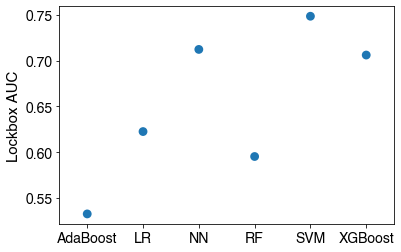

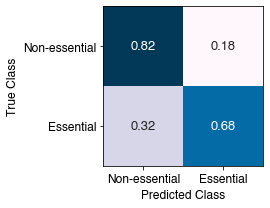

In [29]:
lockbox_eval_df = pd.read_csv(Path(DATA_PATH, 'lockbox_eval.csv'), index_col=0)

_, ax = plt.subplots()
sns.pointplot(x='model', y='auc', data=lockbox_eval_df, join=False, ax=ax)
ax.set_xticklabels(['AdaBoost', 'LR', 'NN', 'RF', 'SVM', 'XGBoost'])
ax.tick_params(axis='both', labelsize=14)
ax.set_xlabel('')
ax.set_ylabel('Lockbox AUC', fontsize=15)
plt.savefig(Path(FIG_PATH, 'essential_lockbox_eval.svg'))

unique_models = lockbox_eval_df['model'].unique()
num_models = 1
if num_models == 1:
    subplot_dims, figsize = (1, 1), (4, 3)
elif num_models == 2:
    subplot_dims, figsize = (1, 2), (8, 3)
elif 3 <= num_models <= 4:
    subplot_dims, figsize = (2, 2), (8, 6)
elif 5 <= num_models <= 6:
    subplot_dims, figsize = (2, 3), (12, 6)
elif 7 <= num_models <= 8:
    subplot_dims, figsize = (2, 4), (12, 6)

_, axs = plt.subplots(*subplot_dims, figsize=figsize)
if num_models == 1:
    axs = [axs]
else:
    axs = axs.flatten()

for model_name, ax in zip(['SVM'], axs):

    model_result_df = lockbox_eval_df[lockbox_eval_df['model'] == model_name]
    tn, fp, fn, tp = model_result_df[['tn', 'fp', 'fn', 'tp']].mean(axis=0)

    conf_mat = np.array([np.array([tn, fp]) / (tn + fp), np.array([fn, tp]) / (fn + tp)])

    sns.heatmap(
        conf_mat,
        cmap="PuBu",
        annot=True,
        annot_kws={'fontsize': 13},
        cbar=False,
        square=True,
        xticklabels=['Non-essential', 'Essential'],
        yticklabels=['Non-essential', 'Essential'],
        ax=ax
    )
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='y', rotation=0)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.set_xlabel('Predicted Class', fontsize=12)
    ax.set_ylabel('True Class', fontsize=12)

if len(axs) > num_models:
    axs[-1].set_visible(False)

plt.tight_layout()
plt.savefig(Path(FIG_PATH, 'ess_conf_mat.svg'))

### Feature Importance

The SVM model seems to be the best and most balanced; what are its feature importances?

In [40]:
4186 - 294

3892

In [38]:
3349 + 838

4187

In [37]:
X.shape

(3349, 1634)

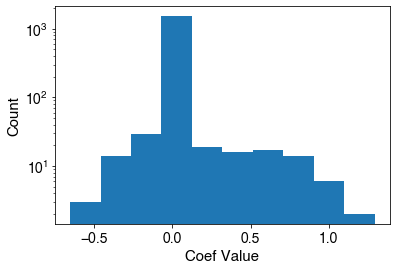

In [30]:
svm_best = test_models['SVM']
coefs = svm_best.coef_.flatten()
coef_df = pd.DataFrame(data={
    'feature': bitome.matrix_row_labels,
    'coef': coefs,
    'coef_abs': np.abs(coefs)
})

_, ax = plt.subplots()
ax.hist(coef_df['coef'], log=True)
ax.set_xlabel('Coef Value', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.tick_params(axis='both', labelsize=14)
plt.savefig(Path(FIG_PATH, 'ess_feat_imp.png'))

In [31]:
high_coef_df = coef_df[coef_df['coef_abs'] > 0.8].sort_values(by='coef_abs', ascending=False)
high_coef_df

,feature,coef,coef_abs
114,COG_D_(-2),1.291937,1.291937
84,COG_J_(-2),1.204689,1.204689
705,residue_exposure_e_(+2),1.095849,1.095849
83,COG_J_(-1),1.089003,1.089003
868,"regulon_CRP,Cra_CRP activator Cra repressor",1.074749,1.074749
85,COG_J_(-3),1.000936,1.000936
138,COG_U_(-2),0.968180,0.968180
144,COG_H_(-2),0.915533,0.915533
142,COG_H_(+3),0.875836,0.875836
186,COG_I_(-2),0.871492,0.871492


In [32]:
coef_to_print = high_coef_df.copy()
coef_to_print.loc[868, 'feature'] = 'CRP/Cra Regulon'
coef_to_print = coef_to_print[['feature', 'coef']]
coef_to_print['coef'] = np.round(coef_to_print['coef'], decimals=2)
coef_to_print = coef_to_print.set_index('feature').T.squeeze()
coef_to_print.to_csv(Path(FIG_PATH, 'ess_coef_table.csv'))
coef_to_print

feature
COG_D_(-2)                 1.29
COG_J_(-2)                 1.20
residue_exposure_e_(+2)    1.10
COG_J_(-1)                 1.09
CRP/Cra Regulon            1.07
COG_J_(-3)                 1.00
COG_U_(-2)                 0.97
COG_H_(-2)                 0.92
COG_H_(+3)                 0.88
COG_I_(-2)                 0.87
COG_D_(-3)                 0.86
COG_J_(+2)                 0.84
COG_D_(-1)                 0.80
COG_I_(+1)                 0.80
Name: coef, dtype: float64

In [119]:
def compare_feature_values(feature_names):
    feat_idxes = [[i for i, lab in enumerate(bitome.matrix_row_labels) if lab == feat_name][0] for feat_name in feature_names]
    feat_label_df = pd.DataFrame(columns=['feature_name', 'feature_value', 'class'])
    for feat_name, feat_idx in zip(feature_names, feat_idxes):
        feat_label_df = feat_label_df.append(pd.DataFrame(data={
            'feature_value': X_lockbox[:, feat_idx],
            'feature_name': feat_name if 'regulon' not in feat_name else 'CRP/Cra Regulon',
            'class': ['Essential' if y_entry == 1 else 'Non-essential' for y_entry in y_lockbox]
        }))
    _, ax = plt.subplots()
    sns.pointplot(y='feature_name', x='feature_value', data=feat_label_df, hue='class', dodge=True, join=False)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylabel('')
    ax.set_xlabel('Feature Value', fontsize=15)
    ax.legend(fontsize=14)

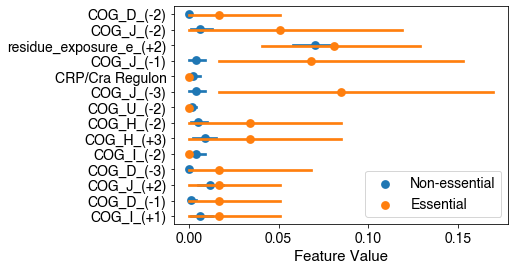

In [120]:
compare_feature_values(list(high_coef_df['feature']))